In [1]:
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

conn = sqlite3.connect("database.sqlite")

tables = ['Country', 'League', 'Match', 'Player', 'Player_Attributes', 'Team', 'Team_Attributes']

df_country = pd.read_sql_query("SELECT * FROM Country", conn)
df_league = pd.read_sql_query("SELECT * FROM League", conn)
df_match = pd.read_sql_query("SELECT * FROM Match", conn)
df_player = pd.read_sql_query("SELECT * FROM Player", conn)
df_player_attributes = pd.read_sql_query("SELECT * FROM Player_Attributes", conn)
df_team = pd.read_sql_query("SELECT * FROM Team", conn)
df_team_attributes = pd.read_sql_query("SELECT * FROM Team_Attributes", conn)

conn.close()

In [2]:
import pandas as pd

merged_df = pd.merge(df_team, df_match, left_on='team_api_id', right_on='home_team_api_id', how='inner')

final_df = pd.merge(merged_df, df_league, left_on='league_id', right_on='id', how='inner')

df_team_league_country = final_df[['team_long_name', 'team_api_id', 'name', 'id_x', 'country_id_y']].drop_duplicates()

df_team_league_country.columns = ['team_name', 'team_api_id', 'league_name', 'league_id', 'country_id']

df_team_league_country = pd.merge(df_team_league_country, df_country, left_on='country_id', right_on='id', how='left')

df_team_league_country = df_team_league_country[['team_name', 'team_api_id', 'league_name', 'league_id', 'name', 'country_id']]
df_team_league_country.columns = ['team_name', 'team_api_id', 'league_name', 'league_id', 'country_name', 'country_id']

df_team_league_country = df_team_league_country.sort_values(['country_name', 'league_name', 'team_name'])

df_team_league_country.to_csv('team_league_country_with_ids.csv', index=False)
teams = pd.merge(df_team_attributes,df_team, on='team_fifa_api_id', how='inner')  # Inner join
teams = pd.merge(teams, df_team_league_country, 
                     left_on='team_api_id_x', 
                     right_on='team_api_id', 
                     how='left')

print(teams.shape)
teams = teams[teams['country_id'].isin([1729,4769,7809,10257,21518])]
print(teams.shape)

teams['date'] = pd.to_datetime(teams['date'])

def get_filter_year():
    year = pd.to_datetime('2008-01-01')
    return year

def aggregate_numeric(x):
    return x.mean()

def aggregate_categorical(x):
    return x.mode().iloc[0]

filter_year = get_filter_year()

filtered_players = teams[teams['date'] >= filter_year]

numeric_columns = filtered_players.select_dtypes(include=['int64', 'float64']).columns
categorical_columns = filtered_players.select_dtypes(include=['object']).columns

columns_to_aggregate = [col for col in filtered_players.columns if col not in ['date', 'year']]

aggregated_players = filtered_players.groupby('team_fifa_api_id').agg({
    **{col: aggregate_numeric for col in numeric_columns if col in columns_to_aggregate},
    **{col: aggregate_categorical for col in categorical_columns if col in columns_to_aggregate}
})



teams = aggregated_players
teams.set_index('team_api_id_x', inplace=True)
print(f"Filtered and aggregated data for players from {filter_year} onwards:")
print(teams.head())
print(f"\nShape of the aggregated data: {aggregated_players.shape}")


has_nan = teams.isnull().values.any()
print(f"Does teams contain NaN values? {has_nan}")

nan_count = teams.isnull().sum()
print("NaN count in each column:")
print(nan_count)

(1473, 35)
(924, 35)
Filtered and aggregated data for players from 2008-01-01 00:00:00 onwards:
                id_x  team_fifa_api_id  buildUpPlaySpeed  \
team_api_id_x                                              
9825.0          73.5               1.0         52.333333   
10252.0         79.5               2.0         65.666667   
8655.0         175.5               3.0         52.500000   
8559.0         200.5               4.0         54.666667   
8455.0         309.5               5.0         61.666667   

               buildUpPlayDribbling  buildUpPlayPassing  \
team_api_id_x                                             
9825.0                         51.0           31.166667   
10252.0                        34.5           58.666667   
8655.0                         45.5           63.833333   
8559.0                         35.5           63.833333   
8455.0                         46.5           45.000000   

               chanceCreationPassing  chanceCreationCrossing  \
team_

In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

df_match_filtered = df_match[df_match['date'] > '2008-01-01']

df_combined = df_match_filtered.merge(df_league, left_on='league_id', right_on='id', suffixes=('', '_league'))
df_combined = df_combined.merge(df_country, left_on='country_id', right_on='id', suffixes=('', '_country'))

df_combined = df_combined.merge(df_team, left_on='home_team_api_id', right_on='team_api_id', suffixes=('', '_home_team'))
df_combined = df_combined.merge(df_team, left_on='away_team_api_id', right_on='team_api_id', suffixes=('', '_away_team'))

df_player_attributes['date'] = pd.to_datetime(df_player_attributes['date'])
df_combined['date'] = pd.to_datetime(df_combined['date'])

def get_team_avg_attributes(team_id, match_date):
    team_players = df_player_attributes[
        (df_player_attributes['date'] <= match_date) & 
        (df_player_attributes['player_api_id'].isin(df_combined[df_combined['home_team_api_id'] == team_id]['home_player_1'].unique()))
    ]
    team_players = team_players.sort_values('date').groupby('player_api_id').last()
    return team_players[['overall_rating', 'potential']].mean()

df_combined['home_team_avg_rating'] = df_combined.apply(lambda row: get_team_avg_attributes(row['home_team_api_id'], row['date'])['overall_rating'], axis=1)
df_combined['home_team_avg_potential'] = df_combined.apply(lambda row: get_team_avg_attributes(row['home_team_api_id'], row['date'])['potential'], axis=1)
df_combined['away_team_avg_rating'] = df_combined.apply(lambda row: get_team_avg_attributes(row['away_team_api_id'], row['date'])['overall_rating'], axis=1)
df_combined['away_team_avg_potential'] = df_combined.apply(lambda row: get_team_avg_attributes(row['away_team_api_id'], row['date'])['potential'], axis=1)

df_combined['match_outcome'] = df_combined.apply(lambda row: 1 if row['home_team_goal'] > row['away_team_goal'] else (0 if row['home_team_goal'] == row['away_team_goal'] else -1), axis=1)

attributes = ['buildUpPlaySpeed', 'buildUpPlayDribbling', 'buildUpPlayPassing', 
              'chanceCreationPassing', 'chanceCreationCrossing', 'chanceCreationShooting', 
              'defencePressure', 'defenceAggression', 'defenceTeamWidth',
              'buildUpPlaySpeedClass', 'buildUpPlayDribblingClass',
              'buildUpPlayPassingClass', 'buildUpPlayPositioningClass',
              'chanceCreationPassingClass', 'chanceCreationCrossingClass',
              'chanceCreationShootingClass', 'chanceCreationPositioningClass',
              'defencePressureClass', 'defenceAggressionClass',
              'defenceTeamWidthClass', 'defenceDefenderLineClass']

for attr in attributes:
    df_combined[f'home_{attr}'] = df_combined['home_team_api_id'].map(teams[attr])
    df_combined[f'away_{attr}'] = df_combined['away_team_api_id'].map(teams[attr])

categorical_columns = ['buildUpPlaySpeedClass', 'buildUpPlayDribblingClass', 'buildUpPlayPassingClass',
                       'buildUpPlayPositioningClass', 'chanceCreationPassingClass', 'chanceCreationCrossingClass', 
                       'chanceCreationShootingClass', 'chanceCreationPositioningClass', 'defencePressureClass',
                       'defenceAggressionClass', 'defenceTeamWidthClass', 'defenceDefenderLineClass']

def one_hot_encode_column(column):
    unique_values = column.unique()
    return column.apply(lambda x: list(unique_values).index(x))

for col in categorical_columns:
    df_combined[f'home_{col}'] = one_hot_encode_column(df_combined[f'home_{col}'])
    df_combined[f'away_{col}'] = one_hot_encode_column(df_combined[f'away_{col}'])
features_for_correlation = [
    'home_team_avg_rating', 'home_team_avg_potential',
    'away_team_avg_rating', 'away_team_avg_potential',
    'home_team_goal', 'away_team_goal', 'match_outcome'
]

for attr in attributes:
    features_for_correlation.append(f'home_{attr}')
    features_for_correlation.append(f'away_{attr}')

print(features_for_correlation)
df_combined.head()

['home_team_avg_rating', 'home_team_avg_potential', 'away_team_avg_rating', 'away_team_avg_potential', 'home_team_goal', 'away_team_goal', 'match_outcome', 'home_buildUpPlaySpeed', 'away_buildUpPlaySpeed', 'home_buildUpPlayDribbling', 'away_buildUpPlayDribbling', 'home_buildUpPlayPassing', 'away_buildUpPlayPassing', 'home_chanceCreationPassing', 'away_chanceCreationPassing', 'home_chanceCreationCrossing', 'away_chanceCreationCrossing', 'home_chanceCreationShooting', 'away_chanceCreationShooting', 'home_defencePressure', 'away_defencePressure', 'home_defenceAggression', 'away_defenceAggression', 'home_defenceTeamWidth', 'away_defenceTeamWidth', 'home_buildUpPlaySpeedClass', 'away_buildUpPlaySpeedClass', 'home_buildUpPlayDribblingClass', 'away_buildUpPlayDribblingClass', 'home_buildUpPlayPassingClass', 'away_buildUpPlayPassingClass', 'home_buildUpPlayPositioningClass', 'away_buildUpPlayPositioningClass', 'home_chanceCreationPassingClass', 'away_chanceCreationPassingClass', 'home_chanceCr

,id,country_id,league_id,season,stage,date,match_api_id,home_team_api_id,away_team_api_id,home_team_goal,...,home_chanceCreationPositioningClass,away_chanceCreationPositioningClass,home_defencePressureClass,away_defencePressureClass,home_defenceAggressionClass,away_defenceAggressionClass,home_defenceTeamWidthClass,away_defenceTeamWidthClass,home_defenceDefenderLineClass,away_defenceDefenderLineClass
0,1,1,1,2008/2009,1,2008-08-17,492473,9987,9993,1,...,0,0,0,0,0,0,0,0,0,0
1,2,1,1,2008/2009,1,2008-08-16,492474,10000,9994,0,...,0,0,0,0,0,0,0,0,0,0
2,3,1,1,2008/2009,1,2008-08-16,492475,9984,8635,0,...,0,0,0,0,0,0,0,0,0,0
3,4,1,1,2008/2009,1,2008-08-17,492476,9991,9998,5,...,0,0,0,0,0,0,0,0,0,0
4,5,1,1,2008/2009,1,2008-08-16,492477,7947,9985,1,...,0,0,0,0,0,0,0,0,0,0


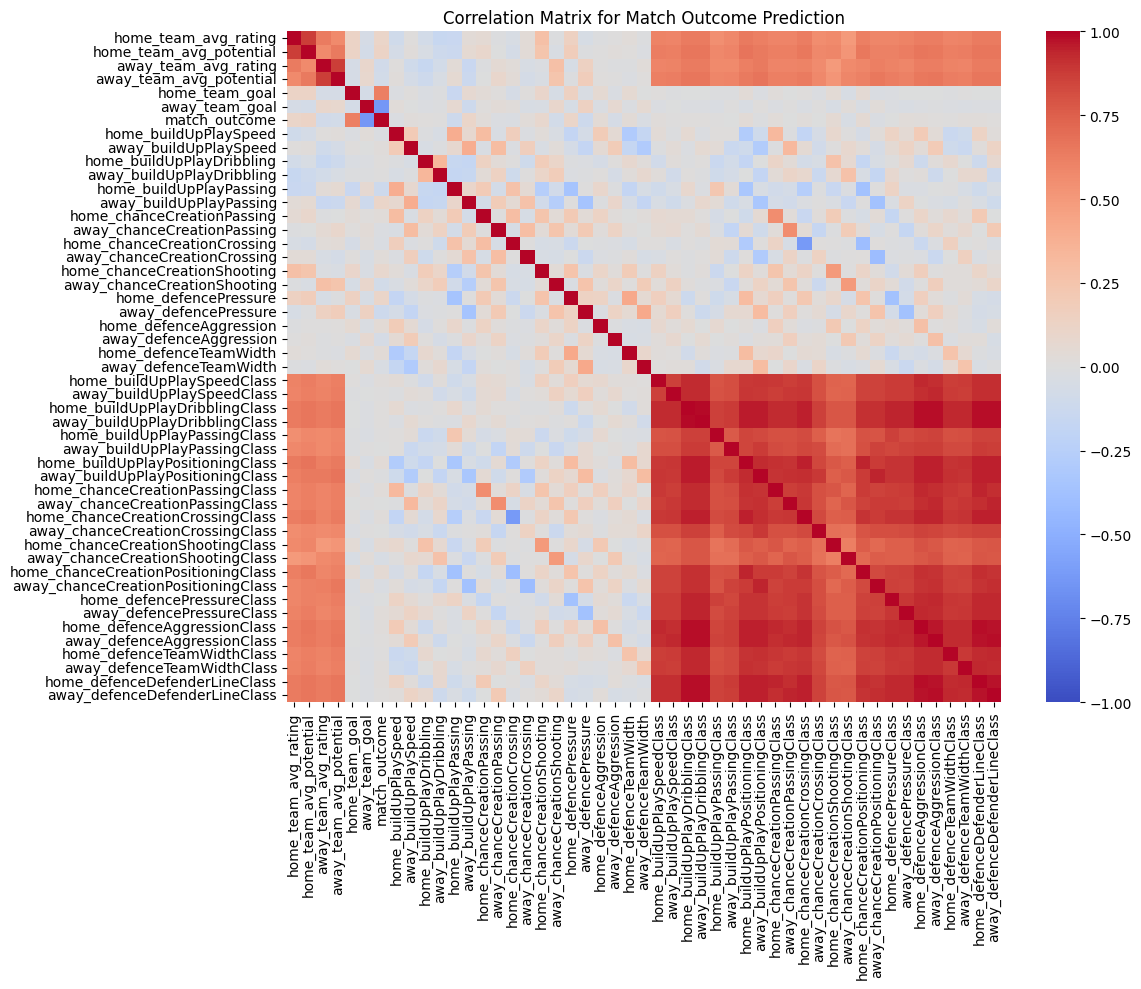

match_outcome                          1.000000
home_team_goal                         0.623921
home_team_avg_potential                0.117871
away_buildUpPlayPassing                0.108595
home_defencePressure                   0.103590
home_team_avg_rating                   0.101783
home_chanceCreationShooting            0.078438
home_chanceCreationShootingClass       0.053025
home_chanceCreationPositioningClass    0.048940
home_defenceAggression                 0.046008
home_buildUpPlayPositioningClass       0.037246
home_defenceTeamWidth                  0.034256
home_chanceCreationPassingClass        0.028792
home_chanceCreationPassing             0.028404
away_chanceCreationCrossing            0.027725
away_defencePressureClass              0.024554
home_buildUpPlaySpeedClass             0.023096
away_defenceTeamWidthClass             0.022270
home_chanceCreationCrossingClass       0.022065
away_buildUpPlaySpeed                  0.018052
home_defenceDefenderLineClass          0

In [6]:

correlation_matrix = df_combined[features_for_correlation].corr()

plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, cmap='coolwarm', vmin=-1, vmax=1, center=0)
plt.title('Correlation Matrix for Match Outcome Prediction')
plt.tight_layout()
plt.show()

print(correlation_matrix['match_outcome'].sort_values(ascending=False))



Random Forest Results:
Accuracy: 0.4394

Classification Report:
              precision    recall  f1-score   support

    Away Win       0.37      0.34      0.36      1470
        Draw       0.26      0.16      0.20      1317
    Home Win       0.52      0.65      0.58      2409

    accuracy                           0.44      5196
   macro avg       0.38      0.38      0.38      5196
weighted avg       0.41      0.44      0.42      5196


Confusion Matrix:
[[ 500  257  713]
 [ 367  215  735]
 [ 470  371 1568]]

Neural Network Results:
Accuracy: 0.4525

Classification Report:
              precision    recall  f1-score   support

    Away Win       0.38      0.32      0.35      1470
        Draw       0.27      0.16      0.20      1317
    Home Win       0.52      0.70      0.60      2409

    accuracy                           0.45      5196
   macro avg       0.39      0.39      0.38      5196
weighted avg       0.42      0.45      0.42      5196


Confusion Matrix:
[[ 465  249  7

/Users/svrao/.virtualenvs/aiml/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


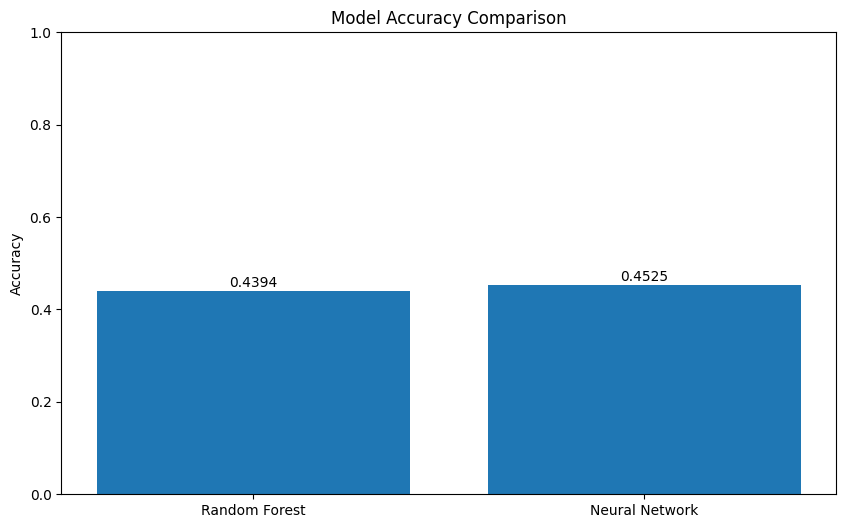

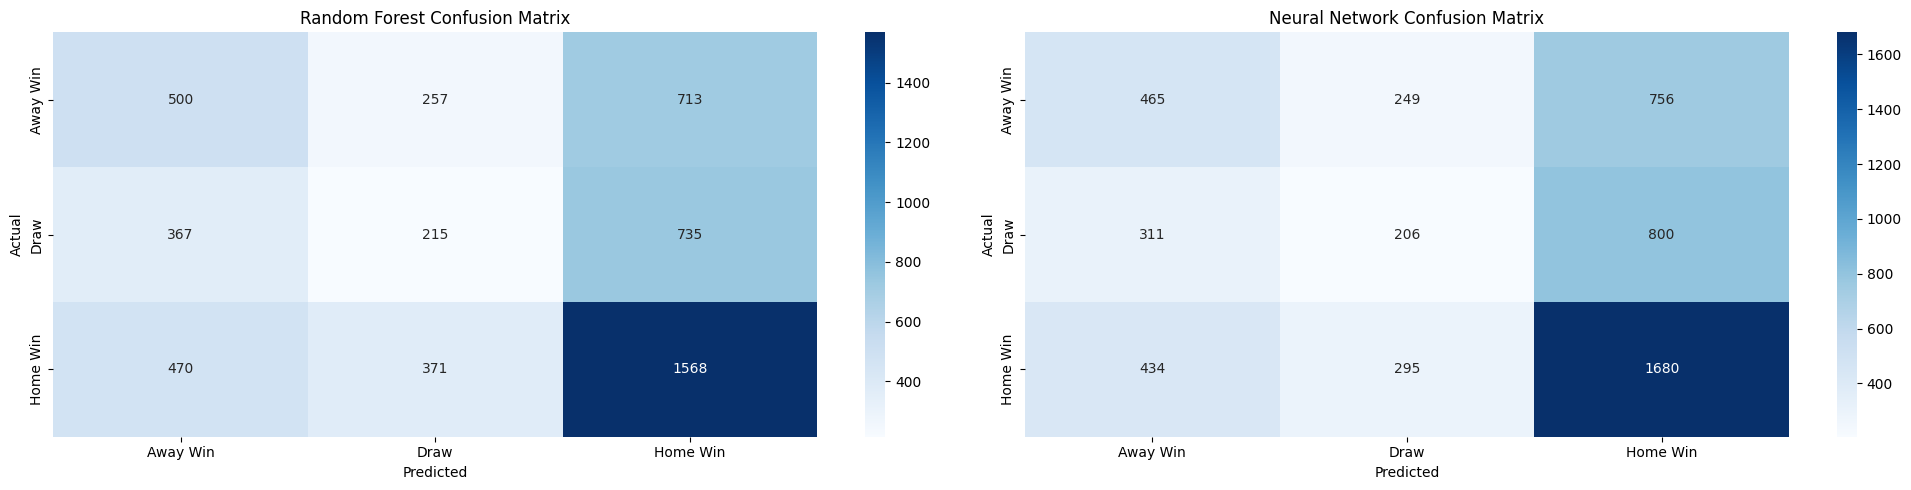

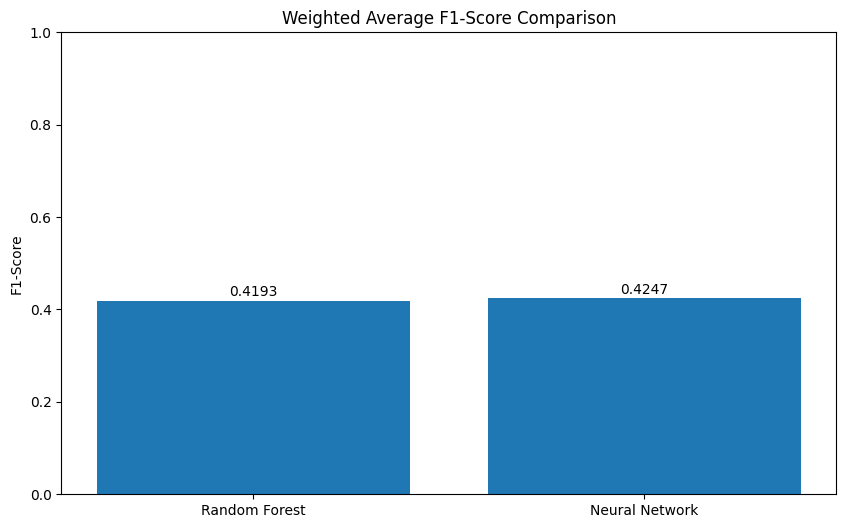

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier


features = [
    'home_team_avg_rating', 'home_team_avg_potential',
    'away_team_avg_rating', 'away_team_avg_potential'
]

df_combined = df_combined.fillna(0)
#print(df_combined.isnull().sum())

X = df_combined[features]
y = df_combined['match_outcome']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

models = {
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42),
    #'XGBoost': XGBClassifier(n_estimators=100, random_state=42),
    'Neural Network': MLPClassifier(hidden_layer_sizes=(500, 100), max_iter=500, random_state=42)
}

results = {}

for name, model in models.items():
    model.fit(X_train_scaled, y_train)
    
    y_pred = model.predict(X_test_scaled)
    
    accuracy = accuracy_score(y_test, y_pred)
    
    results[name] = {
        'accuracy': accuracy,
        'confusion_matrix': confusion_matrix(y_test, y_pred),
        'classification_report': classification_report(y_test, y_pred, target_names=['Away Win', 'Draw', 'Home Win'], output_dict=True)
    }
    
    print(f"\n{name} Results:")
    print(f"Accuracy: {accuracy:.4f}")
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred, target_names=['Away Win', 'Draw', 'Home Win']))
    print("\nConfusion Matrix:")
    print(confusion_matrix(y_test, y_pred))

plt.figure(figsize=(10, 6))
accuracies = [results[model]['accuracy'] for model in models]
plt.bar(models.keys(), accuracies)
plt.title('Model Accuracy Comparison')
plt.ylabel('Accuracy')
plt.ylim(0, 1)
for i, v in enumerate(accuracies):
    plt.text(i, v + 0.01, f'{v:.4f}', ha='center')
plt.show()

class_names = ['Away Win', 'Draw', 'Home Win']

fig, axes = plt.subplots(1, 2, figsize=(20, 5))
for i, (name, model) in enumerate(models.items()):
    sns.heatmap(results[name]['confusion_matrix'], annot=True, fmt='d', cmap='Blues', ax=axes[i],
                xticklabels=class_names, yticklabels=class_names)
    axes[i].set_title(f'{name} Confusion Matrix')
    axes[i].set_xlabel('Predicted')
    axes[i].set_ylabel('Actual')
plt.tight_layout()
plt.show()

f1_scores = {name: results[name]['classification_report']['weighted avg']['f1-score'] for name in models}
plt.figure(figsize=(10, 6))
plt.bar(f1_scores.keys(), f1_scores.values())
plt.title('Weighted Average F1-Score Comparison')
plt.ylabel('F1-Score')
plt.ylim(0, 1)
for i, v in enumerate(f1_scores.values()):
    plt.text(i, v + 0.01, f'{v:.4f}', ha='center')
plt.show()


Random Forest Results:
Accuracy: 0.4509

Classification Report:
              precision    recall  f1-score   support

    Away Win       0.40      0.37      0.38      1470
        Draw       0.26      0.17      0.21      1317
    Home Win       0.53      0.65      0.59      2409

    accuracy                           0.45      5196
   macro avg       0.40      0.40      0.39      5196
weighted avg       0.43      0.45      0.43      5196


Confusion Matrix:
[[ 537  287  646]
 [ 358  230  729]
 [ 449  384 1576]]

Neural Network Results:
Accuracy: 0.4442

Classification Report:
              precision    recall  f1-score   support

    Away Win       0.39      0.32      0.35      1470
        Draw       0.25      0.18      0.21      1317
    Home Win       0.52      0.67      0.59      2409

    accuracy                           0.44      5196
   macro avg       0.39      0.39      0.38      5196
weighted avg       0.42      0.44      0.42      5196


Confusion Matrix:
[[ 467  301  7

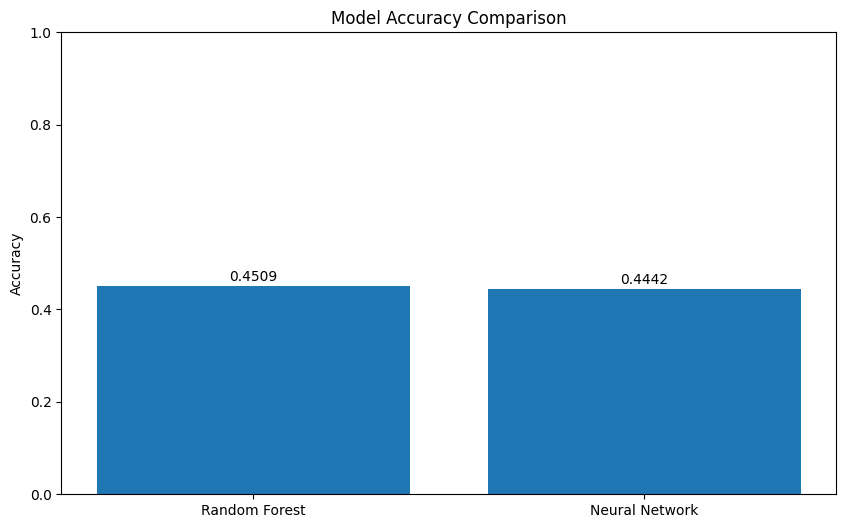

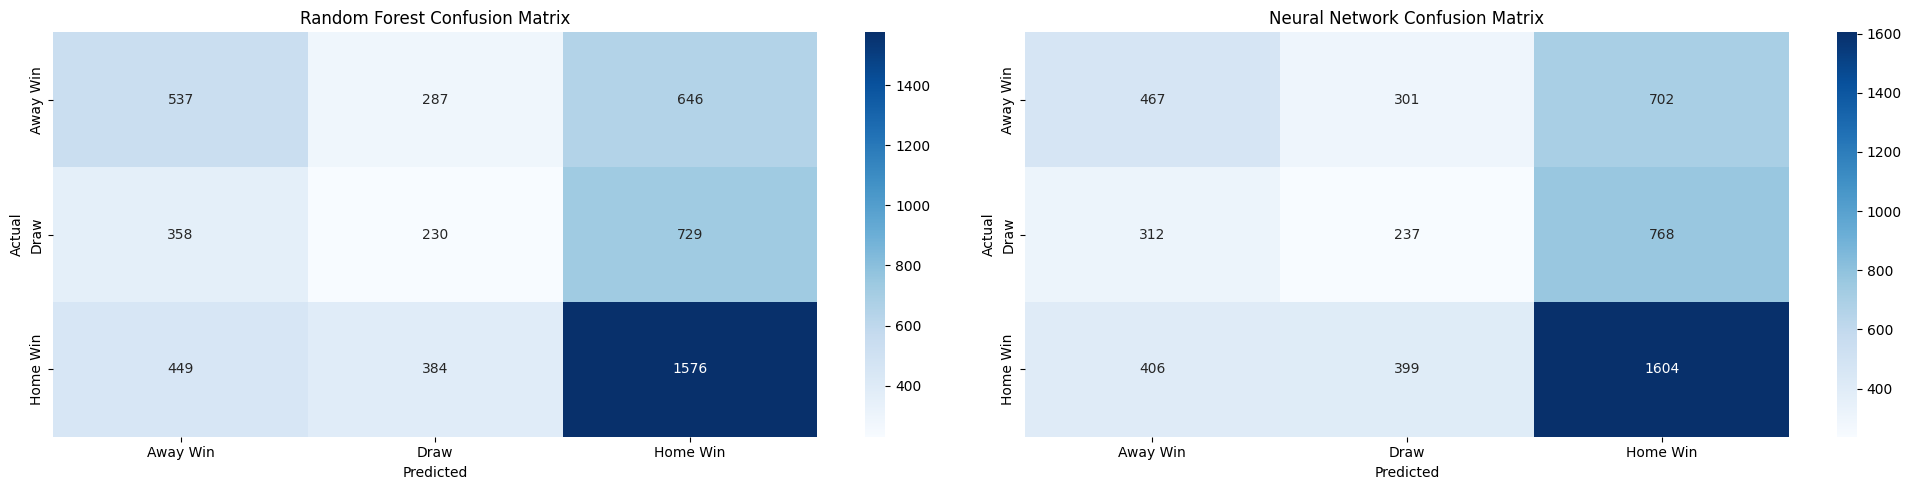

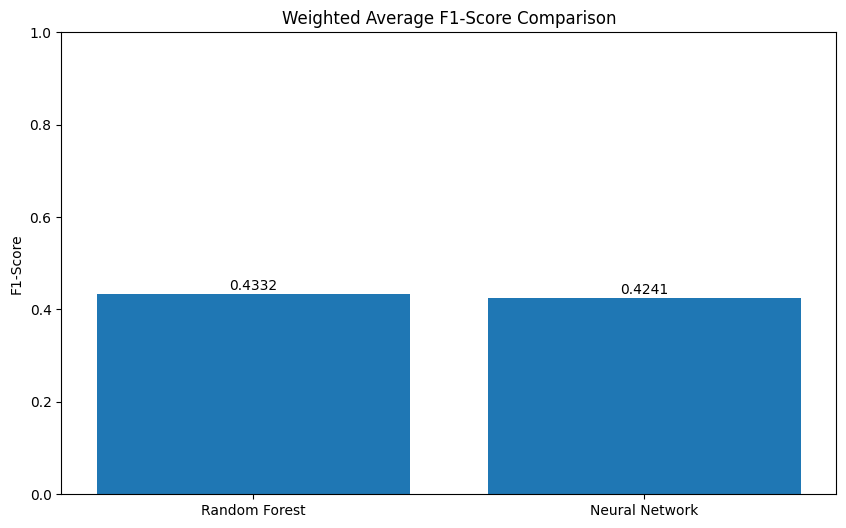

In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier


features = [
    'home_team_avg_rating', 'home_team_avg_potential',
    'away_team_avg_rating', 'away_team_avg_potential'
]
team_attr = ['buildUpPlaySpeed', 'buildUpPlayDribbling', 'buildUpPlayPassing', 
              'chanceCreationPassing', 'chanceCreationCrossing', 'chanceCreationShooting', 
              'defencePressure', 'defenceAggression', 'defenceTeamWidth',
              'buildUpPlaySpeedClass', 'buildUpPlayDribblingClass',
              'buildUpPlayPassingClass', 'buildUpPlayPositioningClass',
              'chanceCreationPassingClass', 'chanceCreationCrossingClass',
              'chanceCreationShootingClass', 'chanceCreationPositioningClass',
              'defencePressureClass', 'defenceAggressionClass',
              'defenceTeamWidthClass', 'defenceDefenderLineClass']
for attr in team_attr:
    features.append(f'home_{attr}')
    features.append(f'away_{attr}')

df_combined = df_combined.fillna(0)
#print(df_combined.isnull().sum())

X = df_combined[features]
y = df_combined['match_outcome']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

models = {
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42),
    #'XGBoost': XGBClassifier(n_estimators=100, random_state=42),
    'Neural Network': MLPClassifier(hidden_layer_sizes=(500, 100), max_iter=500, random_state=42)
}

results = {}

for name, model in models.items():
    model.fit(X_train_scaled, y_train)
    
    y_pred = model.predict(X_test_scaled)
    
    accuracy = accuracy_score(y_test, y_pred)
    
    results[name] = {
        'accuracy': accuracy,
        'confusion_matrix': confusion_matrix(y_test, y_pred),
        'classification_report': classification_report(y_test, y_pred, target_names=['Away Win', 'Draw', 'Home Win'], output_dict=True)
    }
    
    print(f"\n{name} Results:")
    print(f"Accuracy: {accuracy:.4f}")
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred, target_names=['Away Win', 'Draw', 'Home Win']))
    print("\nConfusion Matrix:")
    print(confusion_matrix(y_test, y_pred))

plt.figure(figsize=(10, 6))
accuracies = [results[model]['accuracy'] for model in models]
plt.bar(models.keys(), accuracies)
plt.title('Model Accuracy Comparison')
plt.ylabel('Accuracy')
plt.ylim(0, 1)
for i, v in enumerate(accuracies):
    plt.text(i, v + 0.01, f'{v:.4f}', ha='center')
plt.show()

class_names = ['Away Win', 'Draw', 'Home Win']

fig, axes = plt.subplots(1, 2, figsize=(20, 5))
for i, (name, model) in enumerate(models.items()):
    sns.heatmap(results[name]['confusion_matrix'], annot=True, fmt='d', cmap='Blues', ax=axes[i],
                xticklabels=class_names, yticklabels=class_names)
    axes[i].set_title(f'{name} Confusion Matrix')
    axes[i].set_xlabel('Predicted')
    axes[i].set_ylabel('Actual')
plt.tight_layout()
plt.show()

f1_scores = {name: results[name]['classification_report']['weighted avg']['f1-score'] for name in models}
plt.figure(figsize=(10, 6))
plt.bar(f1_scores.keys(), f1_scores.values())
plt.title('Weighted Average F1-Score Comparison')
plt.ylabel('F1-Score')
plt.ylim(0, 1)
for i, v in enumerate(f1_scores.values()):
    plt.text(i, v + 0.01, f'{v:.4f}', ha='center')
plt.show()